In [1]:
import os
import json
import wandb
import argparse
import itertools
import numpy as np
from time import gmtime, strftime

import soundfile as sf

import torch
import torchaudio
import torch.nn.functional as F
from torch.utils.data import DataLoader

import sys
sys.path.append('../training')
sys.path.append('../training/networks/nansypp')
sys.path.append('../testing')
from hifigan.generator import HifiganGenerator
from hifigan.vctk_loader import VCTK_dataset, LogMelSpectrogram

from datasets.loader import Dataset
from networks.discriminator import Discriminator
from nansypp import Nansypp
from hyface import Nansy, BShall_Nimbre, BShall_Ecapa
# import loss_funcs

from utils import audio_utils
from utils.data_utils import phoneme_inventory, decollate_tensor, combine_fixed_length
from utils import utils

import IPython.display as ipd

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
from PIL import Image as PILImage
import matplotlib.pyplot as plt
cmap = np.array(plt.get_cmap('viridis').colors)

# Setting

## Argument setting

In [3]:
# main_dir = '/home/jaejun/nansy/
config_path = '/home/jaejun/temp_jaejun/hyface/230810/logs/config.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

args.meta_root = '/home/jaejun/hyface/training'
args.base_dir = '/home/jaejun/temp_jaejun/hyface/230810/checkpoints'

## Data

In [4]:
trainset = Dataset(args, meta_root=os.path.join(args.meta_root, 'filelists'),
                        mode='train', datasets=['vctk'], sample_rate=args.data.sample_rate)
testset = Dataset(args, meta_root=os.path.join(args.meta_root, 'filelists'),
                        mode='test', datasets=['vctk'], sample_rate=args.data.sample_rate)
print(f'train:{len(trainset)},test:{len(testset)}')
train_loader = DataLoader(trainset, batch_size=4, collate_fn=trainset.collate, shuffle=True)
test_loader = DataLoader(testset, batch_size=4, collate_fn=testset.collate)

train:35195,test:3982


In [5]:
batch = next(iter(train_loader))
audio = batch['audio']
ling = batch['hubert']
print(audio.shape, ling.shape)

(4, 64000) torch.Size([4, 256, 200])


In [6]:
ipd.Audio(audio[0], rate=16000)

In [44]:
batch = next(iter(train_loader))
audio = batch['audio']
ling = batch['hubert']
print(audio.shape, ling.shape)

(4, 64000) torch.Size([4, 256, 200])


In [45]:
ipd.Audio(audio[0], rate=16000)

In [46]:
ipd.Audio(audio[1], rate=16000)

In [47]:
ipd.Audio(audio[2], rate=16000)

In [48]:
ipd.Audio(audio[3], rate=16000)

# HifiGAN (for vocoding)

In [12]:
# main_dir = '/home/jaejun/nansy/
hfgan_config_path = '/home/jaejun/temp_jaejun/hifigan/logs/config.json'
with open(hfgan_config_path, "r") as f:
    data = f.read()
config = json.loads(data)
hifigan_args = utils.HParams(**config)

In [13]:
melspectrogram = LogMelSpectrogram(sample_rate=hifigan_args.data.sample_rate, n_fft=hifigan_args.data.filter_length,
                hop_length=hifigan_args.data.hop_length, win_length=hifigan_args.data.win_length, n_mels=hifigan_args.data.n_mel_channels, center=False)

/opt/conda/lib/python3.10/site-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


In [14]:
hfgan = HifiganGenerator()

In [15]:
checkpoint_iter = 500
checkpoint_path = f'/home/jaejun/temp_jaejun/hifigan/checkpoints/G_{checkpoint_iter}.pth'
hfgan, _, _, _ = utils.load_checkpoint(checkpoint_path, hfgan)

Loaded checkpoint '/home/jaejun/temp_jaejun/hifigan/checkpoints/G_500.pth' (Epoch 500)


# Nansy

In [52]:
# main_dir = '/home/jaejun/nansy/
config_path = '/home/jaejun/temp_jaejun/hyface/230810/logs/config.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

args.meta_root = '/home/jaejun/hyface/training'
args.base_dir = '/home/jaejun/temp_jaejun/hyface/230810/checkpoints'

In [53]:
if args.model.generator == "nansy":
    hyface = Nansy(args)
elif args.model.generator == "bshall":
    hyface = BShall(args)

In [54]:
index = 1900
checkpoint_path = f'/home/jaejun/temp_jaejun/hyface/230810/checkpoints/G_{index}.pth'
hyface, _, _, _ = utils.load_checkpoint(checkpoint_path, hyface, None)

Loaded checkpoint '/home/jaejun/temp_jaejun/hyface/230810/checkpoints/G_1900.pth' (Epoch 1900)


### Generation

In [55]:
audio_tensor = torch.tensor(audio)
ling_tensor = torch.tensor(ling)
print(audio_tensor.shape, ling_tensor.shape)

torch.Size([4, 64000]) torch.Size([4, 256, 200])


/tmp/ipykernel_45419/3713562185.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ling_tensor = torch.tensor(ling)


In [56]:
timbre_global, timbre_bank = hyface.analyze_timbre(audio_tensor)
mel_synth = hyface.synthesize(ling_tensor, timbre_global, timbre_bank)
mel_synth2 = hyface.synthesize(ling_tensor[0].unsqueeze(0).repeat(4, 1, 1), timbre_global, timbre_bank)

### Vocoding (hfgan)

#### GT

In [57]:
print(audio.shape)
ipd.Audio(audio[0], rate=16000)

(4, 64000)


#### GT Recon

torch.Size([4, 80, 400])


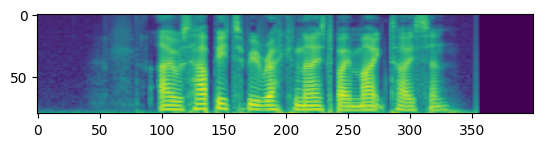

In [129]:
melspec = melspectrogram(torch.tensor(audio))
print(melspec.shape)
pixels = audio_utils.mel_img(melspec[0].detach().numpy(), cmap=cmap)
plt.imshow(pixels)
plt.show()

In [130]:
recon_audio = hfgan(melspec)
print(recon_audio.shape)
ipd.Audio(recon_audio.detach().numpy()[0],rate=16000)

torch.Size([4, 1, 64000])


#### Hyface pred

(80, 400, 3)


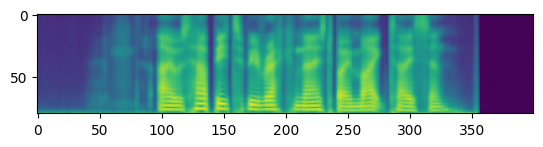

In [60]:
pixels = audio_utils.mel_img(mel_synth[0].detach().numpy(), cmap=cmap)
print(pixels.shape)
plt.imshow(pixels)
plt.show()

In [61]:
synth = hfgan(mel_synth)
print(synth.shape)
ipd.Audio(synth.detach().numpy()[0],rate=16000)

torch.Size([4, 1, 64000])


In [62]:
synth = hfgan(mel_synth2)
print(synth.shape)

torch.Size([4, 1, 64000])


In [63]:
ipd.Audio(synth.detach().numpy()[0],rate=16000)

In [64]:
ipd.Audio(synth.detach().numpy()[1],rate=16000)

In [65]:
ipd.Audio(synth.detach().numpy()[2],rate=16000)

In [66]:
ipd.Audio(synth.detach().numpy()[2],rate=16000)

# BShall_Nimbre

In [67]:
# main_dir = '/home/jaejun/nansy/
config_path = '/home/jaejun/temp_jaejun/hyface/bshall/logs/config.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

args.meta_root = '/home/jaejun/hyface/training'
args.base_dir = '/home/jaejun/temp_jaejun/hyface/bshall/checkpoints'

In [68]:
if args.model.generator == "nansy":
    hyface = Nansy(args)
elif args.model.generator == "bshall" and args.model.timbre.type == "nansy":
    hyface = BShall_Nimbre(args)
elif args.model.generator == "bshall" and args.model.timbre.type == "ecapa":
    hyface = BShall_Ecapa(args)

In [69]:
index = 3900
checkpoint_path = f'/home/jaejun/temp_jaejun/hyface/bshall/checkpoints/G_{index}.pth'
hyface, _, _, _ = utils.load_checkpoint(checkpoint_path, hyface, None)

Loaded checkpoint '/home/jaejun/temp_jaejun/hyface/bshall/checkpoints/G_3900.pth' (Epoch 3900)


In [70]:
audio_tensor = torch.tensor(audio)
ling_tensor = torch.tensor(ling)
print(audio_tensor.shape, ling_tensor.shape)

torch.Size([4, 64000]) torch.Size([4, 256, 200])


/tmp/ipykernel_45419/3713562185.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ling_tensor = torch.tensor(ling)


In [71]:
timbre_global, timbre_bank = hyface.analyze_timbre(audio_tensor)
mel_synth = hyface.synthesize(ling_tensor, (timbre_global, timbre_bank))
mel_synth2 = hyface.synthesize(ling_tensor[0].unsqueeze(0).repeat(4, 1, 1), (timbre_global, timbre_bank))

In [72]:
synth = hfgan(mel_synth2)
print(synth.shape)

torch.Size([4, 1, 64000])


In [73]:
ipd.Audio(synth.detach().numpy()[0],rate=16000)

In [74]:
ipd.Audio(synth.detach().numpy()[1],rate=16000)

In [75]:
ipd.Audio(synth.detach().numpy()[2],rate=16000)

In [76]:
ipd.Audio(synth.detach().numpy()[3],rate=16000)

# BShall_Ecapa

In [83]:
# main_dir = '/home/jaejun/nansy/
config_path = '/home/jaejun/temp_jaejun/hyface/bshall_ecapa/logs/config.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

args.meta_root = '/home/jaejun/hyface/training'
args.base_dir = '/home/jaejun/temp_jaejun/hyface/bshall_ecapa/checkpoints'

In [84]:
if args.model.generator == "nansy":
    hyface = Nansy(args)
elif args.model.generator == "bshall" and args.model.timbre.type == "nansy":
    hyface = BShall_Nimbre(args)
elif args.model.generator == "bshall" and args.model.timbre.type == "ecapa":
    hyface = BShall_Ecapa(args)

In [85]:
index = 2000
checkpoint_path = f'/home/jaejun/temp_jaejun/hyface/bshall_ecapa/checkpoints/G_{index}.pth'
hyface, _, _, _ = utils.load_checkpoint(checkpoint_path, hyface, None)

Loaded checkpoint '/home/jaejun/temp_jaejun/hyface/bshall_ecapa/checkpoints/G_2000.pth' (Epoch 2000)


In [86]:
audio_tensor = torch.tensor(audio)
ling_tensor = torch.tensor(ling)
print(audio_tensor.shape, ling_tensor.shape)

torch.Size([4, 64000]) torch.Size([4, 256, 200])


/tmp/ipykernel_45419/3713562185.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ling_tensor = torch.tensor(ling)


In [87]:
timbre = hyface.analyze_timbre(audio_tensor)
mel_synth = hyface.synthesize(ling_tensor, timbre)
mel_synth2 = hyface.synthesize(ling_tensor[0].unsqueeze(0).repeat(4, 1, 1), timbre)

In [88]:
synth = hfgan(mel_synth2)
print(synth.shape)

torch.Size([4, 1, 64000])


In [89]:
ipd.Audio(synth.detach().numpy()[0],rate=16000)

In [93]:
ipd.Audio(synth.detach().numpy()[1],rate=16000)

In [94]:
ipd.Audio(synth.detach().numpy()[2],rate=16000)

In [95]:
ipd.Audio(synth.detach().numpy()[3],rate=16000)

# BShall_Ecapa (Bshall ac pretrained)

In [111]:
# main_dir = '/home/jaejun/nansy/
config_path = '/home/jaejun/temp_jaejun/hyface/bshall_pretrained_ecapa/logs/config.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

args.meta_root = '/home/jaejun/hyface/training'
args.base_dir = '/home/jaejun/temp_jaejun/hyface/bshall_pretrained_ecapa/checkpoints'

In [112]:
if args.model.generator == "nansy":
    hyface = Nansy(args)
elif args.model.generator == "bshall" and args.model.timbre.type == "nansy":
    hyface = BShall_Nimbre(args)
elif args.model.generator == "bshall" and args.model.timbre.type == "ecapa":
    hyface = BShall_Ecapa(args)

Using cache found in /root/.cache/torch/hub/bshall_acoustic-model_main


Param proj.weight is not in the checkpoint


In [113]:
index = 3000
checkpoint_path = f'/home/jaejun/temp_jaejun/hyface/bshall_pretrained_ecapa/checkpoints/G_{index}.pth'
hyface, _, _, _ = utils.load_checkpoint(checkpoint_path, hyface, None)

Loaded checkpoint '/home/jaejun/temp_jaejun/hyface/bshall_pretrained_ecapa/checkpoints/G_3000.pth' (Epoch 3000)


In [114]:
audio_tensor = torch.tensor(audio)
ling_tensor = torch.tensor(ling)
print(audio_tensor.shape, ling_tensor.shape)

torch.Size([4, 64000]) torch.Size([4, 256, 200])


/tmp/ipykernel_45419/3713562185.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ling_tensor = torch.tensor(ling)


In [115]:
timbre = hyface.analyze_timbre(audio_tensor)
mel_synth = hyface.synthesize(ling_tensor, timbre)
mel_synth2 = hyface.synthesize(ling_tensor[0].unsqueeze(0).repeat(4, 1, 1), timbre)

In [116]:
synth = hfgan(mel_synth2)
print(synth.shape)

torch.Size([4, 1, 64000])


In [117]:
ipd.Audio(synth.detach().numpy()[0],rate=16000)

In [118]:
ipd.Audio(synth.detach().numpy()[1],rate=16000)

In [119]:
ipd.Audio(synth.detach().numpy()[2],rate=16000)

In [120]:
ipd.Audio(synth.detach().numpy()[3],rate=16000)

### this is for temp

In [125]:
test_dir = "/data2/VoxCeleb2/test"
spkrs = os.listdir(test_dir)

In [126]:
cnt = 0
for spkr in spkrs:
    cnt += len(os.listdir(os.path.join(mother_dir, spkr)))
print(len(spkrs), cnt)

118 36237


In [127]:
train_dir = "/data2/VoxCeleb2/dev"
spkrs = os.listdir(train_dir)

In [128]:
cnt = 0
for spkr in spkrs:
    cnt += len(os.listdir(os.path.join(train_dir, spkr)))
print(len(spkrs), cnt)

5994 1092009
